<a href="https://colab.research.google.com/github/biggeo/PyTorch-3D-Medical-Image/blob/master/PyTorch3D_Medica_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required materials
NVIDIA GPU access
Google Colab
See here for more detail
Preprocessed subset of IXI MR brain images available here.
This PyTorch documentation is a vital reference that should be used throughout the project. You will have to refer to the documentation to verify you are using the framework as defined.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
working_dir = "drive/My Drive/IXI/small/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!pwd

/content


# Milestone 1: Load Image

In [15]:
import nibabel as nib
working_dir_1 = "drive/My Drive/IXI/small/t1/"
working_dir_2 = "drive/My Drive/IXI/small/t2/"
filename_1 = "IXI167-HH-1569-T1_fcm.nii.gz"
filename_2 = "IXI167-HH-1569-T2_reg_fcm.nii.gz"
image_1 = nib.load( working_dir_1 + filename_1)
image_2 = nib.load( working_dir_2 + filename_2)
image_data_1 = image_1.get_fdata().transpose()
image_data_2= image_2.get_fdata().transpose()
image_data_1.shape

(90, 120, 120)

T1


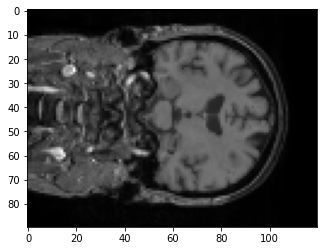

T2


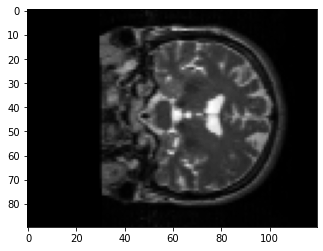

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.imshow(image_data_1[:,:,60],cmap="gist_gray")
print("T1")
plt.show()

print("T2")
plt.imshow(image_data_2[:,:,60],cmap="gist_gray")
plt.show()


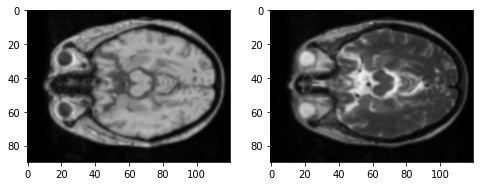

In [17]:
# Slice index
sl = 60   #Range: 0-119

fig=plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(image_data_1[:,sl,:], cmap="gist_gray", interpolation="bicubic")

fig.add_subplot(1, 2, 2)
plt.imshow(image_data_2[:,sl,:], cmap="gist_gray", interpolation="bicubic")
    
plt.show()

# Milestone 2: Transform Image


In [19]:
from torch.utils.data.dataset import Dataset


class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir = None, transforms=None):
        # fill this in
        """
        Args:
            source_dir (string): Directory above t1 and t2 images.
            target_dir (string): Directory to save output.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#        self.source_dir = source_dir
        self.target_dir = target_dir
        self.transforms = transforms
        
        self.t1_dir = os.path.join(source_dir, 't1')
        self.t2_dir = os.path.join(source_dir, 't2')
        
        self.t1_fns = sorted(glob(os.path.join(t1_dir, '*.nii*')))
        self.t2_fns = sorted(glob(os.path.join(t2_dir, '*.nii*')))
        assert len(self.t1_fns) == len(self.t2_fns) and len(self.t1_fns) != 0

    def __len__(self):
        # fill this in
        #ensure the t1 and t2 image numbers are equal, return the number of images of t1
        assert len(self.t1_fns) == len(self.t2_fns) and len(self.t1_fns) != 0
        return len(self.t1_fns)

    def __getitem__(self, idx):
        # fill this in
        # get the t1 and t2 image of idx from the image list
        #return t1 and t2 data
        self.t1_ex, self.t2_ex = nib.load(self.t1_fns[idx]).get_fdata(), nib.load(self.t2_fns[idx]).get_fdata()
        return self.t1_ex, self.t2_ex
class RandomCrop3D:
      
    def __init__(self, output_size):
        #accept int or tuple
        #if int n, output n x n
        #tuple (m x n)
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size) == 3
            self.output_size = output_size

    def __call__(self, sample):
        #sample is tuple of t1 and t2 image data
        t1, t2 = sample

        h, w, d = t1.shape[:]
        new_h, new_w, new_d = self.output_size

        h_offset = np.random.randint(0, h - new_h)
        w_offset = np.random.randint(0, w - new_w)
        d_offset = np.random.randint(0, d - new_d)
        
        new_t1 = t1[h_offset: h_offset + new_h, w_offset: w_offset + new_w, d_offset: d_offset + new_d]
        new_t2 = t2[h_offset: h_offset + new_h, w_offset: w_offset + new_w, d_offset: d_offset + new_d]

        return new_t1, new_t2



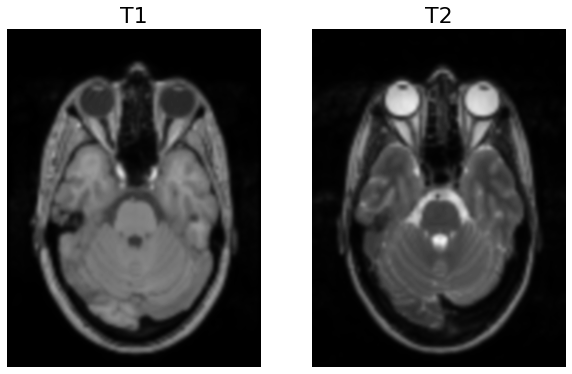

In [20]:
import nibabel as nib
%matplotlib inline
from matplotlib import pyplot as plt
import os
import random
from glob import glob

train_dir = 'drive/My Drive/IXI/small'
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

nft_dataset = NiftiDataset(source_dir = train_dir)

t1_ex, t2_ex = nft_dataset[0]
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(t1_ex[:,60,:], cmap='gray', interpolation="bicubic"); ax1.set_title('T1',fontsize=22); ax1.axis('off'); 
ax2.imshow(t2_ex[:,60,:], cmap='gray', interpolation="bicubic"); ax2.set_title('T2',fontsize=22); ax2.axis('off'); 

# Milestone 3: Create Network


In [21]:
import torch
import torch.nn as nn
import numpy as np

In [25]:
import nibabel as nib
import imageio
import torch
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose
from pathlib import Path
import numpy as np
#from fastcore.utils import *

#from data import dataset, dataloaders, transforms 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [26]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            self.conv_block(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, output_size=(60,60,45)),
            self.conv_block(in_channels=16, out_channels=32, kernel_size=3, stride=1, output_size=(30,30,23)),
        )
        self.decoder = nn.Sequential(
            self.deconv_block(32, 16, kernel_size=3, stride=2,padding=(1, 1, 1),  output_padding=1),
            self.deconv_block(16, 1, kernel_size=3, stride=2, padding=(1, 1, 2), output_padding=1)
        )
        # fill this in, add conv. layers here
    
    def conv_block(self, in_channels, out_channels, kernel_size, stride, output_size):
        return nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d(output_size),
        )
    def deconv_block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, padding=padding, output_padding=output_padding),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        x = torch.sigmoid(x)
        return x

In [27]:
model = ConvNet()
model

ConvNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): ReLU()
      (2): AdaptiveMaxPool3d(output_size=(60, 60, 45))
    )
    (1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): ReLU()
      (2): AdaptiveMaxPool3d(output_size=(30, 30, 23))
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose3d(16, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 2), output_padding=(1, 1, 1))
      (1): ReLU()
    )
  )
)

In [28]:
data_dir = train_dir
transform=Compose([
   transforms.ToTensor()
])
nifti_dataloader = dataloaders.get_dataloader(source_directory=data_dir/'t1',target_directory=data_dir/'t2', transforms=transform)

test_batch = next(iter(nifti_dataloader))

NameError: ignored

In [ ]:
#reference answer for Milestone 3

# def conv(i,o):
#     return (nn.Conv3d(i,o,3,padding=1,bias=False), 
#             nn.BatchNorm3d(o), 
#             nn.ReLU(inplace=True))

# def unet_block(i,m,o):
#     return nn.Sequential(*conv(i,m),*conv(m,o))

# class Unet(nn.Module):
#     def __init__(self, s=32):
#         super().__init__()
#         self.start = unet_block(1,s,s)
#         self.down1 = unet_block(s,s*2,s*2)
#         self.down2 = unet_block(s*2,s*4,s*4)
#         self.bridge = unet_block(s*4,s*8,s*4)
#         self.up2 = unet_block(s*8,s*4,s*2)
#         self.up1 = unet_block(s*4,s*2,s)
#         self.final = nn.Sequential(*conv(s*2,s),nn.Conv3d(s,1,1))
    
#     def forward(self,x):
#         r = [self.start(x)]
#         r.append(self.down1(F.max_pool3d(r[-1],2)))
#         r.append(self.down2(F.max_pool3d(r[-1],2)))
#         x = F.interpolate(self.bridge(F.max_pool3d(r[-1],2)),size=r[-1].shape[2:])
#         x = F.interpolate(self.up2(torch.cat((x,r[-1]),dim=1)),size=r[-2].shape[2:])
#         x = F.interpolate(self.up1(torch.cat((x,r[-2]),dim=1)),size=r[-3].shape[2:])
#         x = self.final(torch.cat((x,r[-3]),dim=1))
#         return x
